In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft as fft
import scipy.signal as signal
from pandas import read_csv, DataFrame
import matplotlib as mpl
import functools
from timeit import default_timer as timer
%matplotlib inline

In [2]:
sdr = adi.ad9361('ip:172.16.1.246')

In [3]:
sdr.tx_destroy_buffer()
sdr.rx_lo = int(100e6)
sdr.tx_lo = int(100e6)
sdr.sample_rate = int(61.44e6)
sdr.rx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.tx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.gain_control_mode = "slow_attack"
sdr.tx_enabled_channels = [1]
sdr.rx_enabled_channels = [1]
sdr.tx_buffer_size = 8192
sdr.rx_buffer_size = 8192
# Подключение: TX2 - RX1
# sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = True
sdr.loopback = 0

In [4]:
# print(sdr.sample_rate)

In [5]:
# fc = 5e6
# ts = 1 / float(sdr.sample_rate)
# N = 2048
# gain = 14
# t = np.arange(0, N * ts, ts)
# i = np.cos(2 * np.pi * t * fc) * 2 ** gain
# q = np.sin(2 * np.pi * t * fc) * 2 ** gain
# iq = i + 1j * q

# sdr.tx_destroy_buffer()
# # Send data cyclically
# sdr.tx(iq)

In [6]:
# Конструктор для сигнала, состоящего из косинусов
def cosines(amplitudes, frequencies):
    return lambda t:  functools.reduce(lambda acc, harmonic: acc + harmonic[0]*np.cos(2 * np.pi * harmonic[1] * t), zip(amplitudes, frequencies), 0)

# Конструктор для сигнала, состоящего из синусов
def sines(amplitudes, frequencies):
    return lambda t:  functools.reduce(lambda acc, harmonic: acc + harmonic[0]*np.sin(2 * np.pi * harmonic[1] * t), zip(amplitudes, frequencies), 0)

def get_averaged_spectrum(sdr, average=10):
    signal = sdr.rx()
    for i in range(average-1):
        signal = signal + sdr.rx()
    signal = signal / average
    spectrum = fft.fftshift(fft.fft(signal))
    frequencies = fft.fftshift(fft.fftfreq(signal.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
    return DataFrame(data = spectrum.imag**2 + spectrum.real**2, index = frequencies)

def dbg(x):
    print(x)
    return x

In [7]:
# t = np.linspace(0, 1, 1000)
# amplitudes = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# frequencies = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
# func = cosines(amplitudes, frequencies)
# plt.plot(t, func(t))
# plt.show()

In [8]:
sdr.rx_lo=int(100e6)
sdr.tx_lo=int(100e6)
freqs = [10e6]
ts = 1 / float(sdr.sample_rate)
N = 8192
gains = [2**6]
t = np.arange(0, N * ts, ts)
i = cosines(gains, freqs)(t)
q = sines(gains, freqs)(t)
iq = i + 1j * q
# part = int(N/8)
# plt.plot(t[:part], i[:part], '.')
# plt.plot(t[:part], q[:part], '.')
# plt.show()

sdr.tx_destroy_buffer()
sdr.tx_destroy_buffer()
# Send data cyclically
sdr.tx(iq)

In [9]:
spectrum = get_averaged_spectrum(sdr, 100)

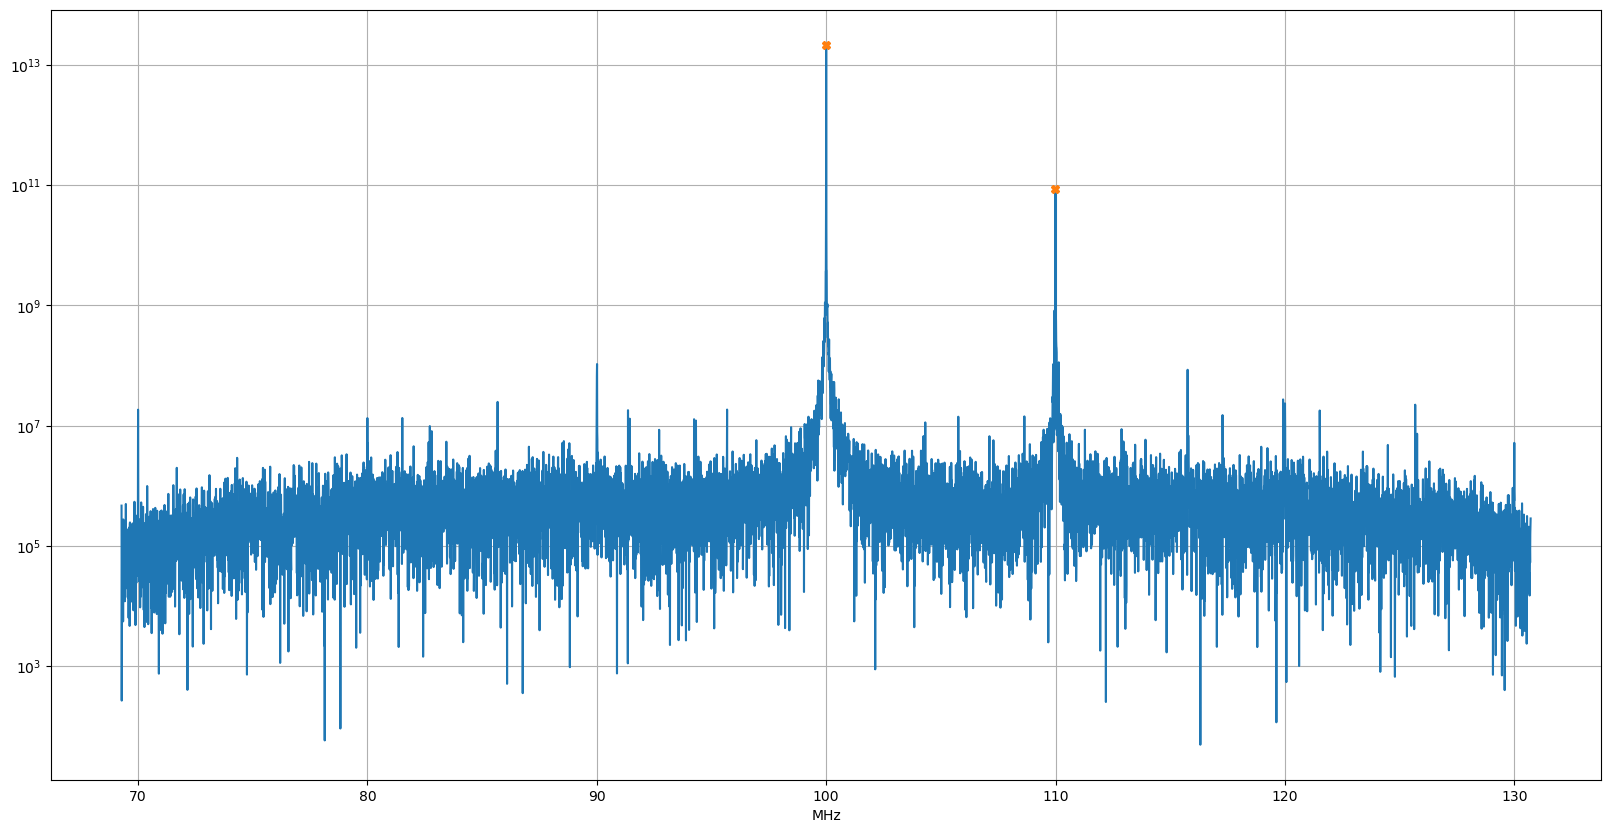

Peak frequencies:
Float64Index([100.0, 109.9975], dtype='float64')


In [10]:
peaks = signal.find_peaks(spectrum[0], prominence = 5e9)[0]
plt.figure(figsize=[20,10])
plt.plot(spectrum)
plt.plot(spectrum.iloc[peaks], "X")
plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
# plt.ylabel("dB")
plt.show()

print("Peak frequencies:")
print(spectrum.iloc[peaks].index)

/tmp/ipykernel_212174/3434539487.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(get_averaged_spectrum(sdr, 100))
/tmp/ipykernel_212174/3434539487.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(get_averaged_spectrum(sdr, 100))


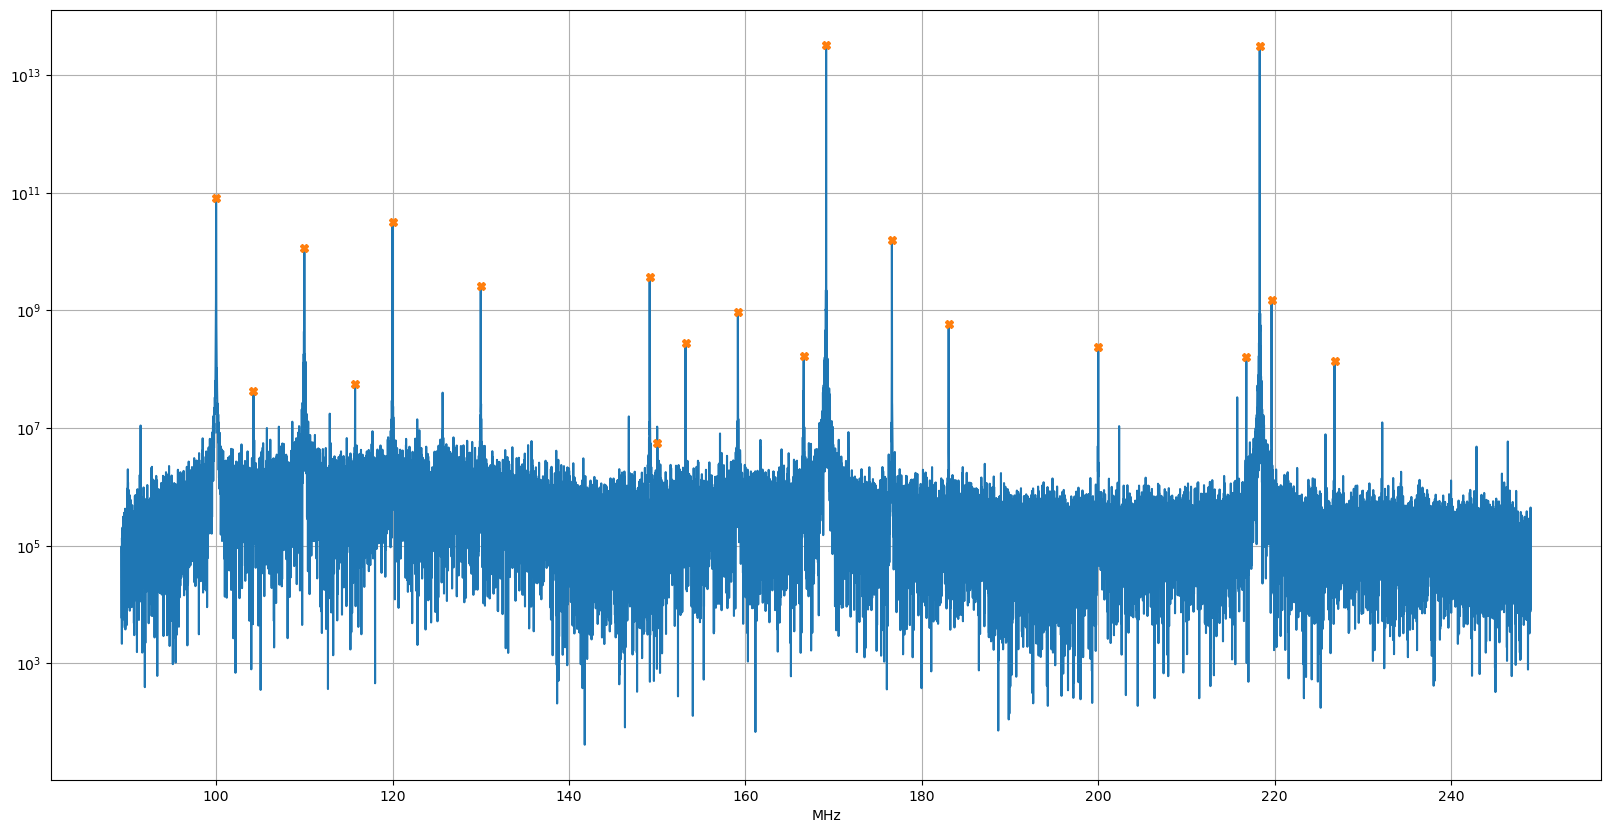

Peak frequencies:
Float64Index([ 99.9975,  104.235, 110.0025,  115.755,    120.0, 129.9975,
                 150.0, 149.1495, 153.2145,  159.147, 166.6095,  169.152,
               176.607,  183.042, 199.9965, 216.7815,  218.304, 219.6465,
              226.7865],
             dtype='float64')


In [11]:
sdr.rx_lo = int(120e6)
data = get_averaged_spectrum(sdr, 100)
step = 2
for i in range(step):
    sdr.rx_lo = sdr.rx_lo + sdr.rx_rf_bandwidth
    data = data.append(get_averaged_spectrum(sdr, 100))

sdr.rx_lo = int(100e6)

peaks = signal.find_peaks(np.log(data[0]), prominence=10)[0]
plt.figure(figsize=[20,10])
plt.plot(data)
plt.plot(data.iloc[peaks], "X")
plt.yscale('log')
plt.xlabel("MHz")
# plt.ylabel("dB")
plt.grid()
plt.show()
print("Peak frequencies:")
print(data.iloc[peaks].index)

In [13]:
data = read_csv('freq.csv', index_col = 0, names=["my_freq", "osc_freq"])
data.index = data.index - 100

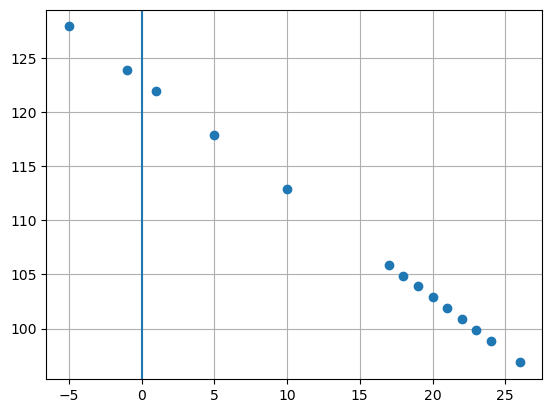

In [14]:
plt.plot(data, 'o')
plt.axvline(0)
plt.grid()
plt.show()

Видимо, проблема в приёмнике, так как сдвиг частоты локального осциллятора прияемника меняет сдвиги моих частот.

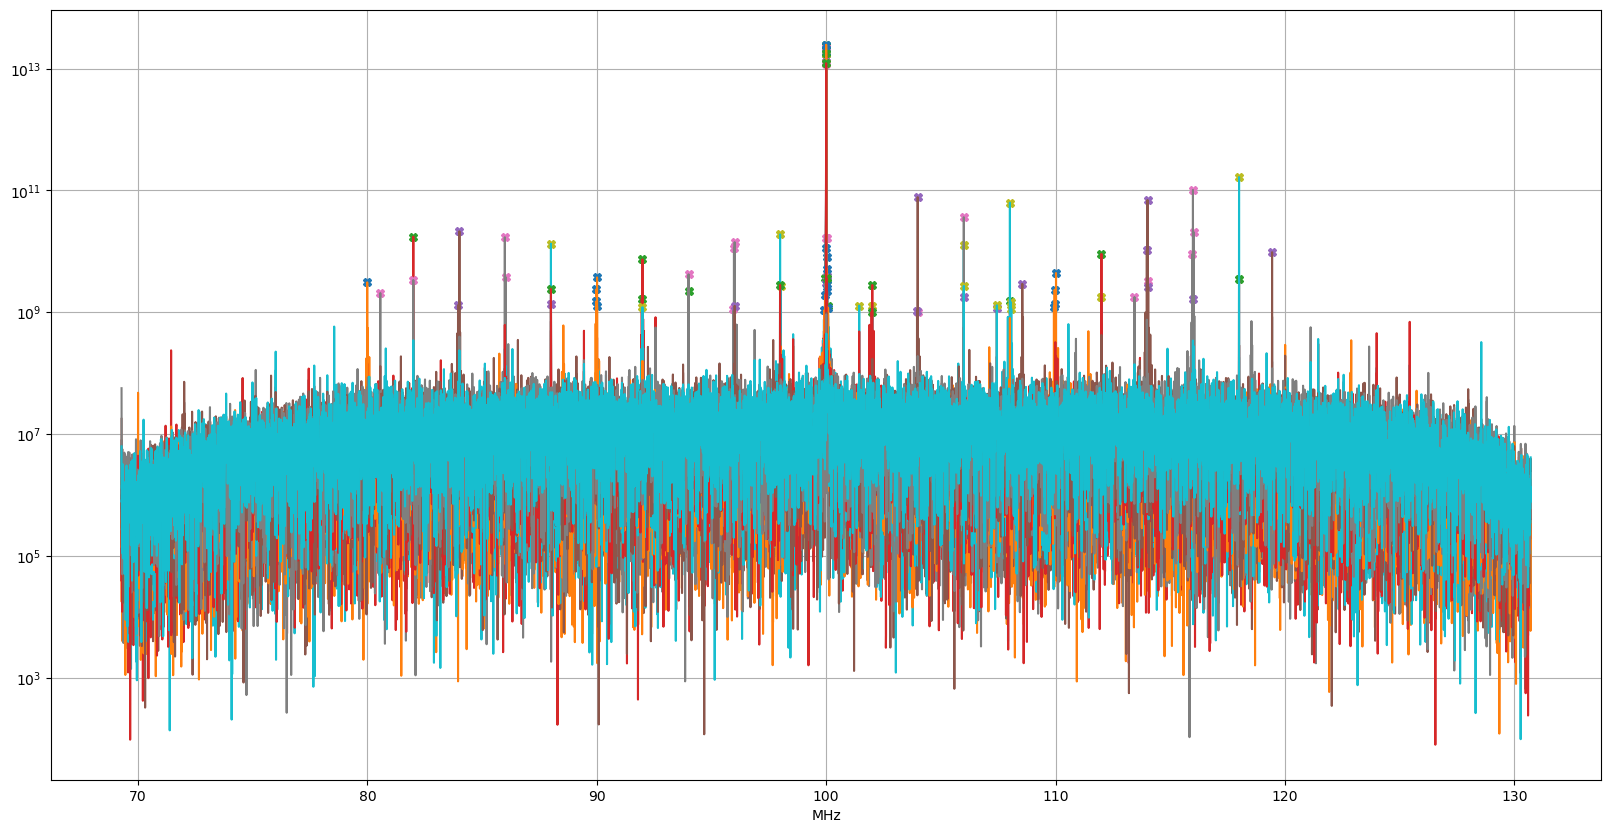

In [15]:
ts = 1 / float(sdr.sample_rate)
N = 2048
gains = [2**4]
t = np.arange(0, N * ts, ts)
plt.figure(figsize=[20,10])
plt.yscale('log')
plt.grid()
plt.xlabel("MHz")

N = 20
step = 2e6
start = -20e6
# cmap = plt.get_cmap('jet',N)

for i in range(N):
    freqs = [i * step + start]
    i = cosines(gains, freqs)(t)
    q = sines(gains, freqs)(t)
    iq = i + 1j * q

    sdr.tx_destroy_buffer()
    sdr.tx_destroy_buffer()
    # Send data cyclically
    sdr.tx(iq)
    
    spectrum = get_averaged_spectrum(sdr, 100)
    peaks = signal.find_peaks(spectrum[0], prominence = 1e9)[0]
    
    plt.plot(spectrum.iloc[peaks], "X")
    plt.plot(spectrum)
    
# plt.ylabel("dB")
# norm = mpl.colors.Normalize(vmin=start,vmax=start + (N-1)*step)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(start, start + N*step, N))
plt.show()

In [16]:
lattice_center = 5 # in length domain, micrometers
lattice_center_freq = 5e6 # Hz
lattice_step = 5 # micrometers
alpha = 0.2e6

laser_amplitude = 2**10
laser_switching_time = 50e-6
laser_switching_speed = laser_amplitude / laser_switching_time
atom_speed = 0.0175e12 # in frequency domain, Hz/s 
def generate_signal(input_array):
    # all the lengths are in micrometers
    lattice_start = lattice_center - int(len(input_array) / 2) * lattice_step
#     print("lattice start", lattice_start)
    signals = []
    for num, atom in np.ndenumerate(input_array):
        start_freq = coord_to_freq(atom)
        end_freq = coord_to_freq(lattice_start + lattice_step * num[0])
        print("start & end freqs", start_freq, end_freq)
        print("transition time", tansition_time(start_freq, end_freq)*1e6, "us")
        signals.append(atom_signal(start_freq, end_freq))
    return np.vectorize(lambda t: functools.reduce(lambda acc, harmonic: acc + harmonic(t), signals,0))

def coord_to_freq(coord):
    # см. #вычисление угла на стр. 1
    return lattice_center_freq + alpha * (coord - lattice_center)

def atom_signal(start_freq, end_freq):
    def harmonic(t):
        freq_sign = 1 if end_freq > start_freq else -1
    #     print(laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed)
        if t < laser_switching_time:
    #         print("turn on")
            return laser_switching_speed * t * np.cos(2*np.pi * start_freq * t)
        elif t < laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = t - laser_switching_time
    #         print("move", start_freq + freq_sign * atom_speed * local_t)
            return laser_amplitude * np.cos(2*np.pi *(start_freq + freq_sign * atom_speed * local_t) * t)
        elif t < laser_switching_time * 2 + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = t - laser_switching_time - freq_sign * (end_freq - start_freq)  / atom_speed
    #         print("turn off", local_t)
            return (laser_amplitude - laser_switching_speed * local_t) * np.cos(2*np.pi * end_freq * t)
        else:
    #         print("off")
            return 0
    return harmonic

def tansition_time(start_freq, end_freq):
    return laser_switching_time * 2 + abs(end_freq - start_freq)  / atom_speed

start & end freqs 4000000.0 3000000.0
transition time 157.14285714285717 us
start & end freqs 6000000.0 4000000.0
transition time 214.28571428571428 us
start & end freqs 7000000.0 5000000.0
transition time 214.28571428571428 us
start & end freqs 8000000.0 6000000.0
transition time 214.28571428571428 us


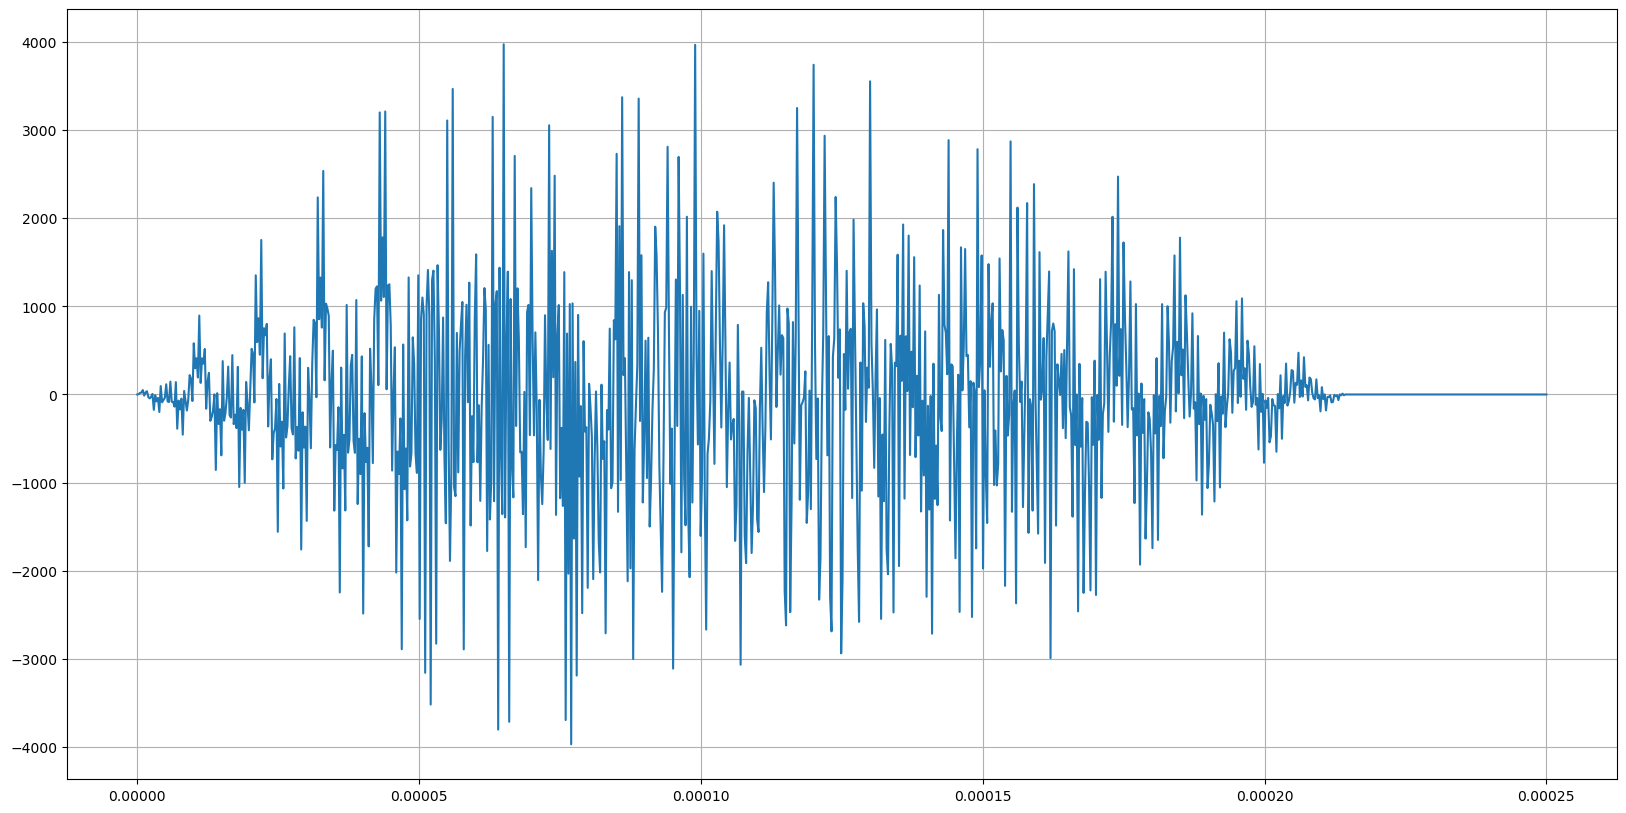

In [17]:
start = 0
end = 2.5e-4
N = 2 ** 10
t = np.linspace(start, end, N)
input_array = np.array([0,10,15,20])
signal_function = generate_signal(input_array)
# func = cosines(amplitudes, frequencies)
signal = signal_function(t)
plt.figure(figsize=[20,10])
plt.plot(t, signal)
plt.grid()
plt.show()

In [18]:
spectrum = (fft.rfft(signal))
frequencies = (fft.rfftfreq(signal.shape[0], (end - start) / N)) / 1e6

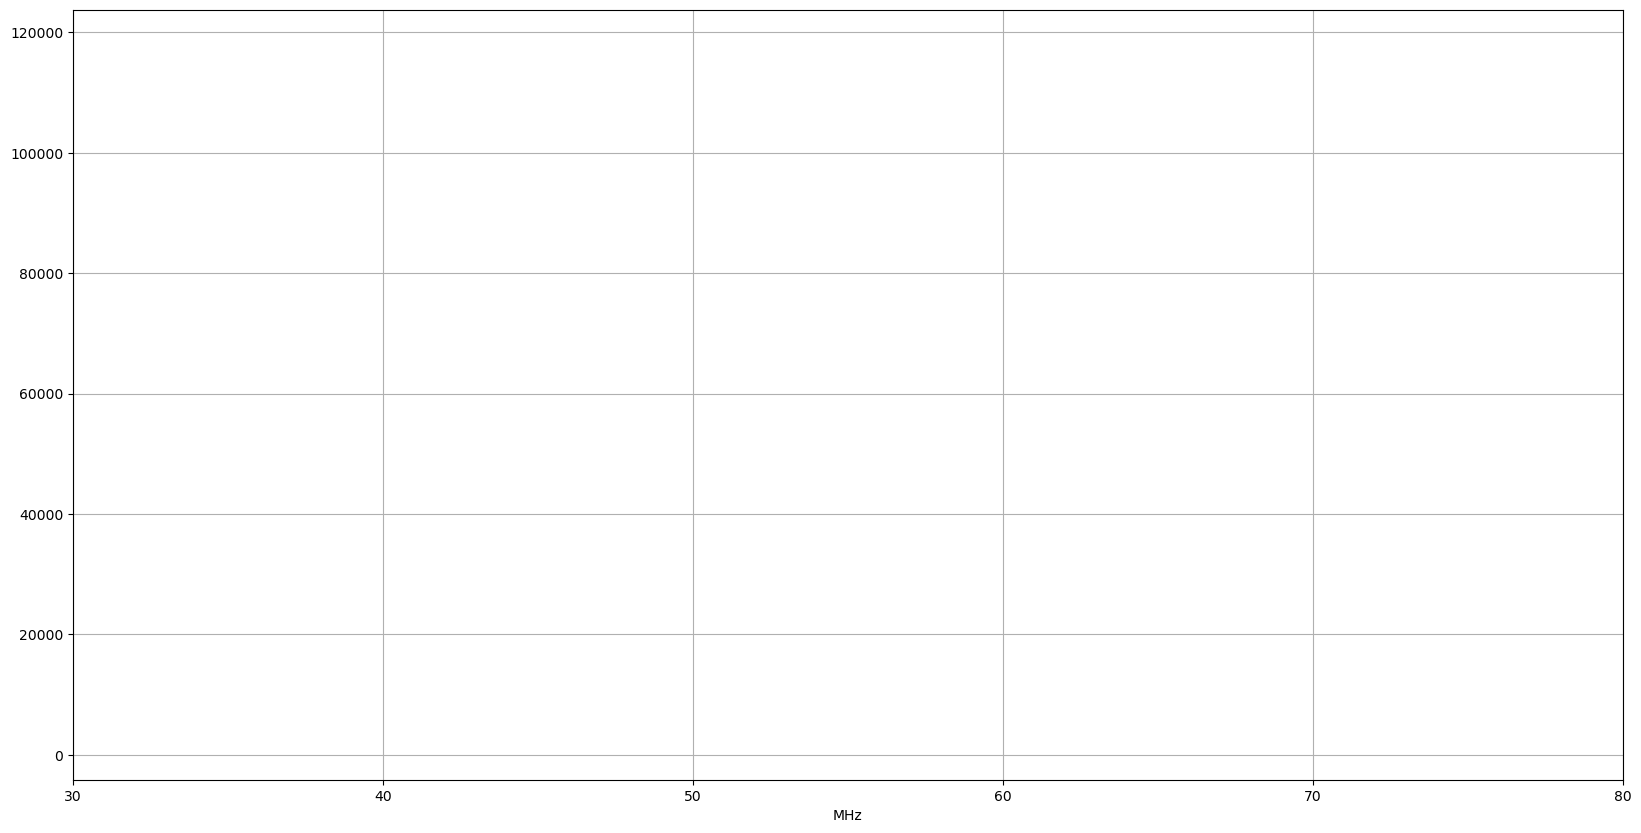

In [19]:
plt.figure(figsize=[20,10])
plt.plot(frequencies, np.abs(spectrum))
plt.xlabel("MHz")
plt.xlim(30,80)
plt.grid()
plt.show()

In [20]:
signal_function = generate_signal(input_array)
print("f = ", signal_function(4.8))

start & end freqs 4000000.0 3000000.0
transition time 157.14285714285717 us
start & end freqs 6000000.0 4000000.0
transition time 214.28571428571428 us
start & end freqs 7000000.0 5000000.0
transition time 214.28571428571428 us
start & end freqs 8000000.0 6000000.0
transition time 214.28571428571428 us
f =  0


In [21]:
t = np.linspace(0, 6, 4096)
start = timer()
input_array = np.array([1,2,3,4,5,6])
signal_function = generate_signal(input_array)
signal = signal_function(t)
end = timer()
print((end - start)*1e3)

start & end freqs 4200000.0 2000000.0
transition time 225.71428571428575 us
start & end freqs 4400000.0 3000000.0
transition time 180.0 us
start & end freqs 4600000.0 4000000.0
transition time 134.28571428571428 us
start & end freqs 4800000.0 5000000.0
transition time 111.42857142857143 us
start & end freqs 5000000.0 6000000.0
transition time 157.14285714285717 us
start & end freqs 5200000.0 7000000.0
transition time 202.85714285714286 us
24.003270009416156
